<a href="https://colab.research.google.com/github/Heffx/CNN/blob/master/Projeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [2]:
# Conferindo se o CUDA esta disponivel

verificaGPU = torch.cuda.is_available()

if not verificaGPU:
  print('CUDA INDISPONIVEL, TREINANDO COM CPU')
else:
  print('CUDA DISPONIVEL, TREINANDO COM GPU')

CUDA DISPONIVEL, TREINANDO COM GPU


In [3]:
!pip3 install torchvision

In [0]:
# Fazendo download e descompactando o dataset
!wget -cq https://github.com/udacity/pytorch_challenge/raw/master/cat_to_name.json
!wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
!rm -r flower_data || true
!unzip -qq flower_data.zip

In [0]:
import json
import os
import flower_data
from torchvision import datasets
import torchvision
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, models, transforms
import glob
import numpy as np
from skimage import data, io, filters
from scipy.optimize import minimize
import time
import copy 


#Carregando, Normalizando e Criando vetor de Imagens

In [6]:
#Carregando treino com data loader


imagenet_train = torchvision.datasets.ImageFolder('flower_data/train/')

imagenet_valid = torchvision.datasets.ImageFolder('flower_data/valid/')
                                                 
                                                 
print(imagenet_train)
print(imagenet_valid)
data_loader_train = torch.utils.data.DataLoader(imagenet_train,
                                          batch_size=32,
                                          shuffle=True)

data_loader_valid = torch.utils.data.DataLoader(imagenet_valid,
                                          batch_size=32,
                                          shuffle=True)
                                          


print(data_loader_train)
print(data_loader_valid)



Dataset ImageFolder
    Number of datapoints: 6552
    Root Location: flower_data/train/
    Transforms (if any): None
    Target Transforms (if any): None
Dataset ImageFolder
    Number of datapoints: 818
    Root Location: flower_data/valid/
    Transforms (if any): None
    Target Transforms (if any): None


In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    data_loader_train: transforms.Compose([
        # Redimensiona a imagem em (224,224)
        transforms.RandomResizedCrop(224),
        # Inverte horizontalmente a imagem
        transforms.RandomHorizontalFlip(),
        # Transforma em matriz de dados unicos
        transforms.ToTensor(),
        # Normaliza as imagens atraves de desvio padrão(Valores retirados de outro trabalho) 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    data_loader_valid: transforms.Compose([
        # Transformação da imagem para tamanho de entrada
        transforms.Resize(256),
        # Recorta a imagem no centro
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print(data_transforms)

with open('cat_to_name.json', 'r') as f:
      labels_name = json.load(f)
print(labels_name)

{<torch.utils.data.dataloader.DataLoader object at 0x7f11371962e8>: Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), <torch.utils.data.dataloader.DataLoader object at 0x7f1135892be0>: Compose(
    Resize(size=256, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}
{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love i

In [0]:
# Função que le as imagens
def read_images(path):
  classes = glob.glob(path + '*')
  # Recebe o nome de todos os arquivos
  im_files = []
  # Recebe a quantidade de todas as classes
  size_classes = []
  
  #print(classes)
  
  #for i in enumerate(labels_name):
   # nome = labels_name[i]
    #print(nome.split(","))
  
  for i in classes:
    # Agrupa as imagens por classe
    name_images_per_class = glob.glob(i+ '/*')
    im_files = im_files+name_images_per_class
    # Agrupa a quantidade de cada classe no vetor size_class
    size_classes.append(len(name_images_per_class))
  # Agrupa as imagens e classe em uma matriz de zeros
  labels = np.zeros((len(im_files), len(classes)))
  ant = 0
  
  for id_i, i in enumerate(size_classes):
    labels[ant:ant+i, id_i] = 1
    ant = i
  # Carrega uma coleção de imagens
  collection = io.imread_collection(im_files)
  # Vetor de saída
  data = []
  
  for id_i, i in enumerate(collection):
    # Concatena no vetor data a matriz da imagem e o nome da imagem
    data.append((i, im_files[id_i]))
  return np.asarray(data) , np.asarray(labels)

In [0]:
# Load Train

# Chamada do vetor de imagens para treino
path = 'flower_data/train/'
data = []
labels = []
# Chamada da função que le as imagens
data, labels = read_images(path)

# Valid Train

path_val = 'flower_data/valid/'
data_val = []
labels_val = []
# Chamada da função que le as imagens
data_val, labels_val = read_images(path_val)

In [10]:
print(labels)
print(type(data))
print(data.shape)
print(labels.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
<class 'numpy.ndarray'>
(6552, 2)
(6552, 102)


(500, 667, 3)

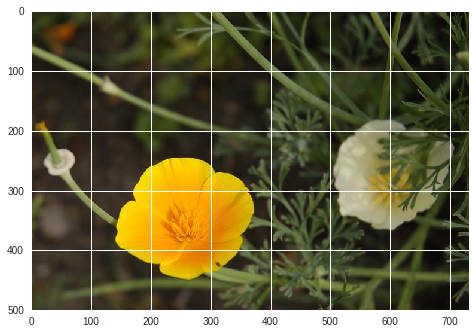

In [11]:
#Plotando uma das imagens
plt.imshow(data[6551][0], cmap = 'Greys_r')
data[0][0].shape

## Pre-treino

In [0]:
model = models.vgg19(pretrained=True)

In [13]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

In [0]:
#Definindo a arquitetura da rede

class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(25088,4096)
    self.fc2 = nn.Linear(4096,102)
    
  def forward(self,x):
    #verifica se o tensor está "flattened (achatado)"
    x = x.view(x.shape[0],-1)
    
    x = F.relu(self.fc1(x))
    x = F.log_softmax(self.fc2(x),dim=1)
    
    return x

In [0]:
classifier = Classifier()
for param in model.parameters():
    param.requires_grad = False

In [0]:
model.classifier = classifier

In [0]:
def train_model(model, criteria, optimizer, scheduler,    
                                      num_epochs=5, device='cuda'):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in [data_loader_train, data_loader_valid]:
            if phase == data_loader_train:
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loader_train[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [0]:
# Criteria NLLLoss which is recommended with Softmax final layer
criteria = nn.NLLLoss()
# Observe that all parameters are being optimized
optim = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 4 epochs
sched = lr_scheduler.StepLR(optim, step_size=4, gamma=0.1)
# Number of epochs
eps=10

In [19]:
model_ft = train_model(model, criteria, optim, sched, eps, 'cuda')

Epoch 0/9
----------


TypeError: ignored